In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter,CategoricalParameter, ScalarOutcome, ema_logging,
                           perform_experiments,TimeSeriesOutcome,IntegerParameter,Scenario)
import seaborn as sns

In [2]:
car = pd.read_csv('Car/car_km.csv')
train = pd.read_csv('Train/train_km.csv')
bus = pd.read_csv('Bus_tram_metro/bus_tram_km.csv')

In [3]:
#car = car[['Name','BUURTCODE','car km per capita']]
#train = train[['Name','train km per capita']]
#tram = bus[['Name','tram km per capita']]
passenger_km = pd.merge(car,train,on=['Name'],how='inner')
passenger_km = pd.merge(passenger_km,bus,on=['Name'],how='inner')
passenger_km['Total'] = passenger_km['car km per capita'] + passenger_km['train km per capita'] + passenger_km['tram km per capita']  
passenger_km['public_transport'] = passenger_km['train km per capita'] + passenger_km['tram km per capita']
passenger_km['Total_GWP'] = passenger_km['GWP_car'] + passenger_km['GWP_train'] + passenger_km['GWP_bustram']
passenger_km = passenger_km[['Name','Total','public_transport','Total_GWP']]
hague = pd.read_excel('hague_data.xlsx')
input_data = pd.merge(passenger_km,hague,on=['Name'],how='inner')
input_data['Cars'] = input_data['Cars']/input_data['Population']

In [4]:
input_data.head()
maxi = input_data['Income'].max()
mini = input_data['Income'].min()
input_data['income_normalized'] = 1 + (np.exp(1)-1)*(input_data['Income']-mini)/(maxi-mini)
input_data = input_data.sort_values(by=['income_normalized'])

In [22]:
input_data1 = input_data[["ownership_reduction_lowcharge","ownership_reduction_mediumcharge","ownership_reduction_highcharge"]]
input_data1.columns = ['Low parking charge','Medium parking charge','High parking charge']
input_data2 = input_data1.melt()
input_data2['Income'] = input_data['Income'].tolist() + input_data['Income'].tolist() + input_data['Income'].tolist()

In [25]:
input_data2.columns =['Scenario','Value','Variable']

In [27]:
input_data2.head()

,Scenario,Value,Variable
0,Low parking charge,0.833333,12200.0
1,Low parking charge,0.836275,12800.0
2,Low parking charge,0.836760,12900.0
3,Low parking charge,0.839642,13500.0
4,Low parking charge,0.840118,13600.0


Text(0, 0.5, 'Car ownership level compared to current case')

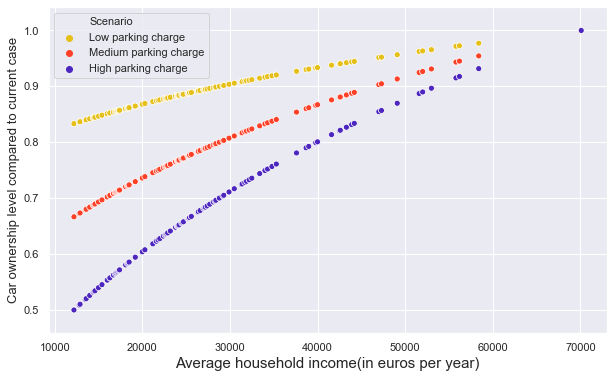

In [30]:
sns.set()
sns.scatterplot(x="Variable",y="Value",hue="Scenario",data=input_data2,palette="CMRmap_r")
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.xlabel('Average household income(in euros per year)',fontsize=15)
plt.ylabel('Car ownership level compared to current case',fontsize=13)

In [6]:
low_charge_case = 0.8333333
medium_charge_case = 0.6666666
high_charge_case = 0.5
input_data = input_data.reset_index(drop=True)
for i in range (0,len(input_data)):
    input_data.loc[i,'ownership_reduction_lowcharge'] = low_charge_case + (1-low_charge_case)*np.log(input_data.loc[i,'income_normalized'])
    input_data.loc[i,'ownership_reduction_mediumcharge'] = medium_charge_case + (1-medium_charge_case)*np.log(input_data.loc[i,'income_normalized'])
    input_data.loc[i,'ownership_reduction_highcharge'] = high_charge_case + (1-high_charge_case)*np.log(input_data.loc[i,'income_normalized']) 
input_data = input_data.dropna()
input_data = input_data.reset_index(drop=True)

In [16]:
def mobility_policy(fare_change,petrol_price_change,income_change,car_ownership_change,travel_demand):
    pop_sum = 0
    frac_sum = 0
    if (car_ownership_change == 1):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_lowcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']

    if (car_ownership_change == 2):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_mediumcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']

    if (car_ownership_change == 3):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_highcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']
    reduction = frac_sum/pop_sum
    
    return {'reduction':reduction}

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)
model = Model('simpleModel', function=mobility_policy)
model.uncertainties = [RealParameter("petrol_price_change", -0.3, 0.3),
                           RealParameter("income_change",0.03,0.2),
                           RealParameter("travel_demand", 0.01, 0.2)]
model.levers = [CategoricalParameter("car_ownership_change",[1,2,3]),
               RealParameter("fare_change",-0.3,-0.05)]
    
model.outcomes = [ScalarOutcome('reduction')]

In [18]:
mobility_policy(-0.2,0.05,0.03,1,0.1)

{'reduction': -0.020041425946523594}

In [19]:
from ema_workbench import (MultiprocessingEvaluator,SequentialEvaluator)

with SequentialEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000,policies=10)

[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [21]:
experiments,outcomes=results

In [41]:
experiments.head()

,income_change,petrol_price_change,travel_demand,car_ownership_change,fare_change,scenario,policy,model
0,0.103026,0.191827,0.166323,1,-0.16425,100,1,simpleModel
1,0.092120,-0.208249,0.056220,1,-0.16425,101,1,simpleModel
2,0.119417,-0.081874,0.102580,1,-0.16425,102,1,simpleModel
3,0.058227,-0.100923,0.159082,1,-0.16425,103,1,simpleModel
4,0.064298,-0.193138,0.163516,1,-0.16425,104,1,simpleModel


In [42]:
experiments_unc = experiments[['income_change','petrol_price_change','travel_demand','car_ownership_change','fare_change']]
res = outcomes['reduction']
#y = res < np.percentile(res, 10)
y = res<0

In [47]:
from ema_workbench.analysis import prim
prim_alg = prim.Prim(experiments_unc,y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 3285 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.134, coverage: 0.4079147640791476, density: 1.0 restricted_dimensions: 3


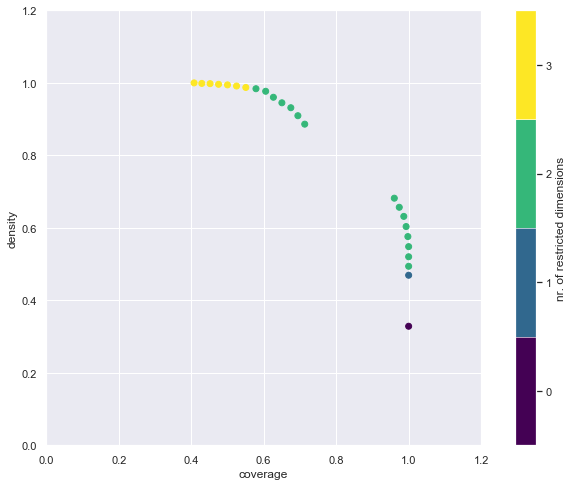

In [97]:
sns.set()
box1.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

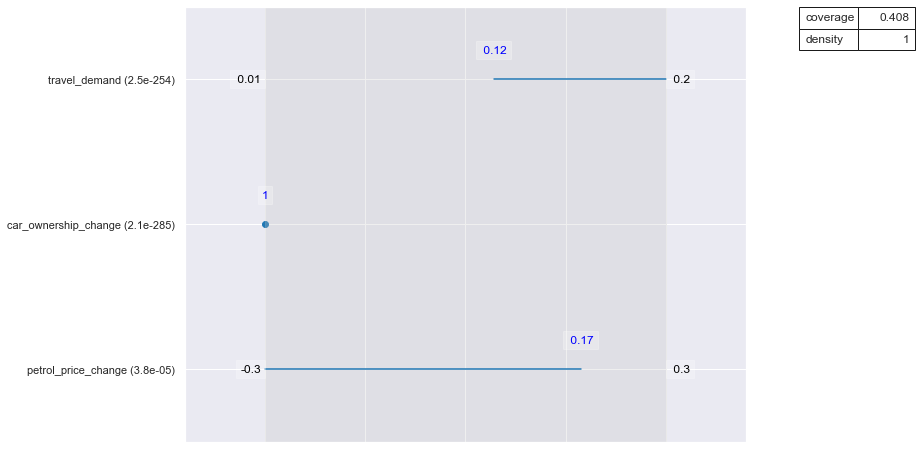

In [98]:
sns.set()
box1.inspect(style='graph')
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

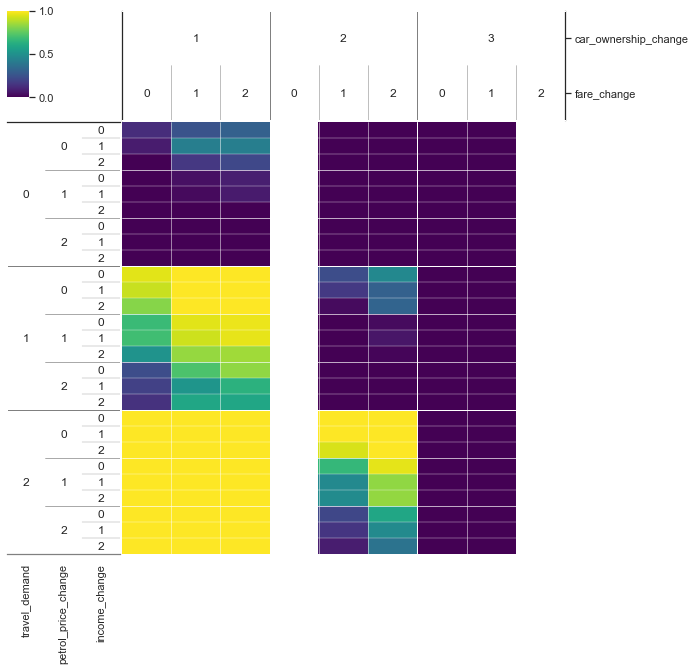

In [99]:
from ema_workbench.analysis import dimensional_stacking
sns.set()
dimensional_stacking.create_pivot_plot(experiments_unc, y, nr_levels=3)
plt.show()

In [81]:
reference = Scenario('reference', petrol_price_change=0, income_change=0.11,travel_demand=0.1)
#with SequentialEvaluator(model) as evaluator:
#    experiment,outcomes = evaluator.perform_experiments(scenarios=Scenario,policies=1)
policies=10000
results = perform_experiments(model,reference, policies)

[MainProcess/INFO] performing 1 scenarios * 10000 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [93]:
experiments,outcomes = results
experiments['reduction']=outcomes['reduction']

In [94]:
experiments.loc[experiments['car_ownership_change']==1,'policy'] = 'low charge car parking'
experiments.loc[experiments['car_ownership_change']==2,'policy'] = 'medium charge car parking'
experiments.loc[experiments['car_ownership_change']==3,'policy'] = 'high charge car parking'
#for i in range (0,len(experiments)):
#    plt.plot(experiments.loc[i,'fare_change'],experiments.loc[i,'reduction'],color=experiments.loc[i,'color'])
    

Text(0, 0.5, 'Emission reduction due to mobility(in terms of original emissions)')

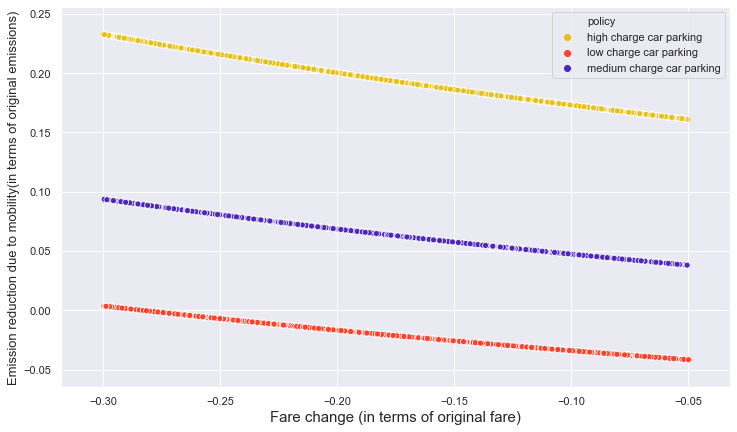

In [116]:
sns.set()
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x="fare_change", y="reduction",hue="policy",data=experiments,palette="CMRmap_r")
plt.xlabel('Fare change (in terms of original fare)',fontsize=15)
plt.ylabel('Emission reduction due to mobility(in terms of original emissions)',fontsize=13)

In [90]:
experiments['car_ownership_change'].unique()

array([3, 1, 2], dtype=object)

In [122]:
def mobility_policy_df(fare_change,petrol_price_change,income_change,car_ownership_change,travel_demand):
    pop_sum = 0
    frac_sum = 0
    if (car_ownership_change == 1):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_lowcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']

    if (car_ownership_change == 2):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_mediumcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']

    if (car_ownership_change == 3):
        for i in range (0,len(input_data)):
            delta_ln = -0.4*(np.log(1+fare_change)) + 0.55*(np.log(1+travel_demand)) + 0.34*(np.log(1+petrol_price_change) + np.log(1+income_change)) -1.37*np.log(input_data.loc[i,'ownership_reduction_highcharge'])
            input_data.loc[i,'change_in_public_transport'] = np.exp(delta_ln)
            if ((travel_demand+1)*input_data.loc[i,'Total']<(input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])):
                input_data.loc[i,'GWP_reduction'] = (input_data.loc[i,'Total_GWP']/365)- (0.0703*input_data.loc[i,'change_in_public_transport']*input_data.loc[i,'public_transport'])
            else:
                input_data.loc[i,'GWP_reduction'] = -0.3314*((travel_demand*input_data.loc[i,'Total'])-(input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1)))-(0.0703*input_data.loc[i,'public_transport']*(input_data.loc[i,'change_in_public_transport']-1))
            input_data.loc[i,'GWP_reduction_frac'] = 365*input_data.loc[i,'GWP_reduction']/input_data.loc[i,'Total_GWP']
            frac_sum = frac_sum + input_data.loc[i,'GWP_reduction_frac']*input_data.loc[i,'Population']
            pop_sum = pop_sum + input_data.loc[i,'Population']
    reduction = frac_sum/pop_sum
    
    return input_data

In [144]:
#low_charge = mobility_policy_df(0,0,0,1,0)
#medium_charge = mobility_policy_df(0,0,0,2,0)
high_charge = mobility_policy_df(0,0,0,3,0)

In [145]:
 high_charge.to_csv('highcharge.csv',index=False)

In [155]:
high_charge = pd.read_csv('highcharge.csv')
medium_charge = pd.read_csv('mediumcharge.csv')
low_charge = pd.read_csv('lowcharge.csv')

In [156]:
low_charge = low_charge[['Name','GWP_reduction_frac']]
low_charge = low_charge.merge(car[['Name','BUURTCODE']],on=['Name'],how='inner')
medium_charge = medium_charge[['Name','GWP_reduction_frac']]
medium_charge = medium_charge.merge(car[['Name','BUURTCODE']],on=['Name'],how='inner')
high_charge = high_charge[['Name','GWP_reduction_frac']]
high_charge = high_charge.merge(car[['Name','BUURTCODE']],on=['Name'],how='inner')

In [157]:
high_charge.to_csv('highcharge.csv',index=False)
medium_charge.to_csv('mediumcharge.csv',index=False)
low_charge.to_csv('lowcharge.csv',index=False)